In [20]:
import os
import numpy as np
from tqdm import tqdm
from einops import rearrange
import config as cfg
from data import DataModule
from model import LightningModel
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "/homes/l17vedre/Bureau/Sanssauvegarde/patnum_output/final_logs/test/lightning_logs/version_0/checkpoints"

In [3]:
checkpoints = sorted(list(map(lambda x: os.path.join(ROOT_DIR, x), os.listdir(ROOT_DIR))))

In [4]:
models = {}
for i, checkpoint in tqdm(enumerate(checkpoints[:1])):
    models[i] = LightningModel.load_from_checkpoint(checkpoint)

1it [00:00,  7.31it/s]


In [5]:
datamodule_config = cfg.DataModule(
    input_root        = "/homes/l17vedre/Bureau/Sanssauvegarde/patnum_data/test/to_predict/",
    target_resolution = (1.5*2, 1.5*2, 8),
    target_shape      = (128, 128, 26),
    class_indexes     = (1, ),
    patch_size        = None,
    train_batch_size  = 1,
    val_batch_size    = 1,
    num_workers       = 4
)

In [6]:
datamodule = DataModule.from_config(datamodule_config)
datamodule.setup(stage='test')

In [7]:
def dice_score(outputs, targets, ratio=0.5):
    outputs = outputs.flatten()
    targets = targets.flatten()
    outputs[outputs > ratio] = np.float32(1)
    outputs[outputs < ratio] = np.float32(0)    
    return float(2 * (targets * outputs).sum())/float(targets.sum() + outputs.sum())

In [8]:
inputs, targets = next(iter(datamodule.test_dataloader()))

In [23]:
inputs = inputs.cuda()
targets = targets.cuda()
model = models[0].cuda()
model = model.eval()

In [24]:
outputs = model(inputs)
outputs = outputs[0]

In [25]:
inputs_array         = inputs.cpu().detach().numpy()
predicted_mask_array = outputs.cpu().detach().numpy()
target_mask_array    = targets.cpu().detach().numpy()

In [26]:
inputs_array         = rearrange(inputs_array, 'b c d w h -> (b c d) w h ')
target_mask_array    = rearrange(target_mask_array, 'b c d w h -> (b c d) w h ')
predicted_mask_array = rearrange(predicted_mask_array, 'b c d w h -> (b c d) w h ')
print(inputs_array.shape)
print(predicted_mask_array.shape)
print(target_mask_array.shape)

print(inputs_array.shape)

(26, 128, 128)
(26, 128, 128)
(26, 128, 128)
(26, 128, 128)


In [27]:
dice_score(predicted_mask_array, target_mask_array)

0.8824475877140319

In [28]:
def compare_images(arrays_list, cmap='gray', colorbar=False):
    plt.figure(figsize=(20, 15))
    for i in range(len(arrays_list)):
        plt.subplot(1, len(arrays_list), i+1)
        if arrays_list[i].shape[0] == 3: # image
            image_array = rearrange(arrays_list[i], 'c h w -> h w c')
        else:
            image_array = arrays_list[i]
        plt.imshow(image_array, cmap=cmap, interpolation='nearest')
        plt.axis('off')
        if colorbar:
            plt.colorbar(shrink=(1/len(arrays_list)))
    plt.show()

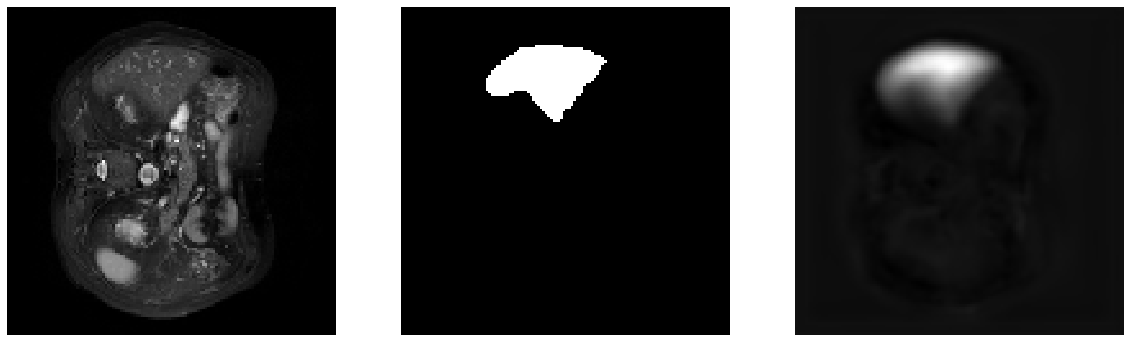

In [29]:
d = inputs_array.shape[0]
compare_images([inputs_array[d//2,:,:],  target_mask_array[d//2,:,:],  predicted_mask_array[d//2,:,:]])

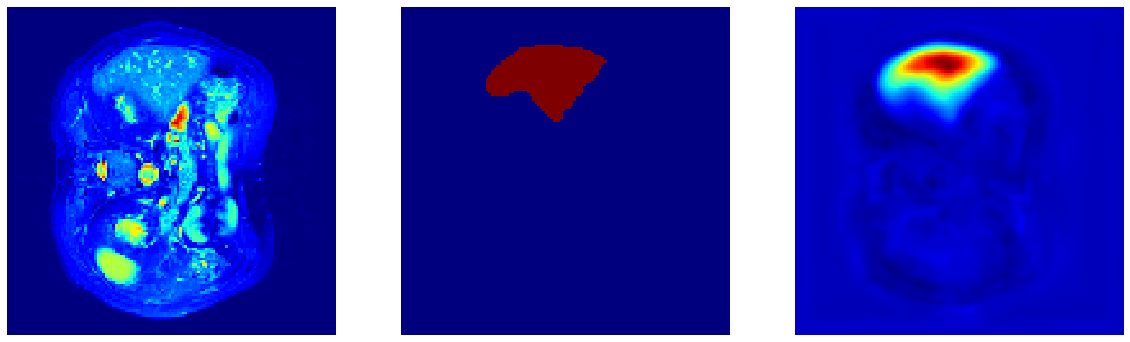

In [30]:
compare_images([inputs_array[d//2,:,:],  target_mask_array[d//2,:,:],  predicted_mask_array[d//2,:,:]], cmap='jet')

In [43]:
attention_maps = model.net.get_attention_map(inputs)

In [44]:
STAGE_INDEX = 0
FMAP_INDEX  = 0

In [47]:
sample_attention_map = attention_maps[STAGE_INDEX].cpu().detach().numpy()

In [48]:
sample_attention_map.shape

(1, 16, 26, 128, 128)

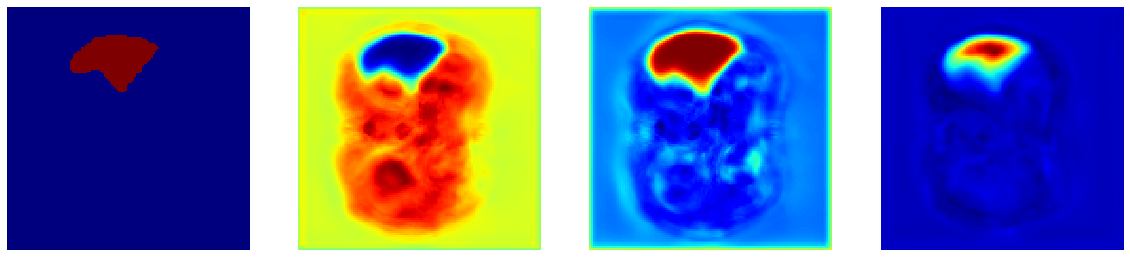

In [67]:
compare_images([target_mask_array[d//2,:,:], sample_attention_map[0,14,d//2,:,:], sample_attention_map[0,12,d//2,:,:], predicted_mask_array[d//2,:,:]], cmap='jet')